<a href="https://colab.research.google.com/github/ShubhamP1028/DeepLearningTute/blob/main/Stock_NeuralNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

--------------------------------
Full neural network (2+ hidden layers) with gradient tracking plots
- Auto-selects a numeric target (prefers 'Close' if present)
- Predicts next-step target (shift -1)
- Chronological 80/20 split
- He init for ReLU layers, Xavier for output
- Tracks per-layer gradient L2 norms (weights only)
- Saves loss and gradient plots to PNG
---

In [2]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler

# ------------- CONFIG -------------
CSV_PATH = "stock_data.csv"
EPOCHS = 50
BATCH_SIZE = 64
LR = 1e-3
HIDDEN1 = 64
HIDDEN2 = 32
OUTDIR = Path("./outputs")
OUTDIR.mkdir(parents=True, exist_ok=True)
SEED = 42
# ----------------------------------

# Reproducibility-ish
np.random.seed(SEED)
torch.manual_seed(SEED)

def load_dataset(csv_path: str):
    df = pd.read_csv(csv_path)
    if df.empty:
        raise ValueError("Loaded DataFrame is empty.")
    return df

def choose_target_and_features(df: pd.DataFrame):
    """
    - Prefer 'Close' if it exists and is numeric.
    - Else pick the last numeric column as target.
    - Features = all other numeric columns except the target.
    - Returns: feature_cols, target_name, use_next_step=True
    """
    numeric_df = df.select_dtypes(include=[np.number]).copy()
    if numeric_df.shape[1] == 0:
        raise ValueError("No numeric columns found for modeling.")

    if "Close" in df.columns and pd.api.types.is_numeric_dtype(df["Close"]):
        target_name = "Close"
    else:
        target_name = numeric_df.columns[-1]

    feature_cols = [c for c in numeric_df.columns if c != target_name]

    # If typical OHLCV columns exist, prioritize their ordering in features
    ohlcv = [c for c in ["Open", "High", "Low", "Close", "Volume"] if c in feature_cols]
    if len(ohlcv) >= 2:
        feature_cols = list(dict.fromkeys(ohlcv + feature_cols))  # keep OHLCV first, then others

    return feature_cols, target_name, True  # always predict next step in this script

def build_xy(df: pd.DataFrame, feature_cols, target_name, use_next_step=True):
    X_all = df[feature_cols].astype(float).copy()
    y_series = df[target_name].astype(float).copy()

    if use_next_step:
        y_all = y_series.shift(-1)
        X_all = X_all.iloc[:-1, :]
        y_all = y_all.iloc[:-1]
    else:
        y_all = y_series

    # drop any remaining NaNs
    mask = X_all.notnull().all(axis=1) & y_all.notnull()
    X_all = X_all[mask]
    y_all = y_all[mask]

    return X_all, y_all

def chronological_split(X, y, val_frac=0.2):
    n = len(X)
    split_idx = int(n * (1 - val_frac))
    X_train = X.iloc[:split_idx, :].values
    y_train = y.iloc[:split_idx].values.reshape(-1, 1)
    X_val = X.iloc[split_idx:, :].values
    y_val = y.iloc[split_idx:].values.reshape(-1, 1)
    return X_train, y_train, X_val, y_val

class MLP(nn.Module):
    def __init__(self, in_dim, h1, h2, out_dim):
        super().__init__()
        self.fc1 = nn.Linear(in_dim, h1)
        self.fc2 = nn.Linear(h1, h2)
        self.out = nn.Linear(h2, out_dim)
        self.act = nn.ReLU()
        self._init_weights()

    def _init_weights(self):
        # He init for ReLU layers; Xavier for output
        nn.init.kaiming_normal_(self.fc1.weight, nonlinearity="relu")
        nn.init.zeros_(self.fc1.bias)
        nn.init.kaiming_normal_(self.fc2.weight, nonlinearity="relu")
        nn.init.zeros_(self.fc2.bias)
        nn.init.xavier_normal_(self.out.weight)
        nn.init.zeros_(self.out.bias)

    def forward(self, x):
        x = self.act(self.fc1(x))
        x = self.act(self.fc2(x))
        return self.out(x)

def get_batches(X_t, y_t, bs):
    # chronological mini-batches (no shuffle)
    n = len(X_t)
    for i in range(0, n, bs):
        yield X_t[i:i+bs], y_t[i:i+bs]

def main():
    # 1) Load data
    df = load_dataset(CSV_PATH)
    print("Columns:", list(df.columns))
    print("Head:\n", df.head(5))

    # 2) Choose target & features
    feature_cols, target_name, use_next_step = choose_target_and_features(df)
    print(f"Chosen target: {target_name} (predict next-step: {use_next_step})")
    print(f"Feature columns ({len(feature_cols)}): {feature_cols}")

    # 3) Build X, y
    X_all, y_all = build_xy(df, feature_cols, target_name, use_next_step=use_next_step)
    print(f"Dataset after alignment: X shape={X_all.shape}, y shape={y_all.shape}")

    # 4) Chronological split
    X_train, y_train, X_val, y_val = chronological_split(X_all, y_all, val_frac=0.2)

    # 5) Scale (fit on train only)
    x_scaler = StandardScaler()
    X_train_s = x_scaler.fit_transform(X_train)
    X_val_s = x_scaler.transform(X_val)

    y_scaler = StandardScaler()
    y_train_s = y_scaler.fit_transform(y_train)
    y_val_s = y_scaler.transform(y_val)

    # 6) Tensors
    X_train_t = torch.tensor(X_train_s, dtype=torch.float32)
    y_train_t = torch.tensor(y_train_s, dtype=torch.float32)
    X_val_t = torch.tensor(X_val_s, dtype=torch.float32)
    y_val_t = torch.tensor(y_val_s, dtype=torch.float32)

    # 7) Model / loss / opt
    input_dim = X_train_t.shape[1]
    model = MLP(input_dim, HIDDEN1, HIDDEN2, out_dim=1)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=LR)

    # 8) Train with gradient tracking
    train_losses, val_losses = [], []
    grad_history = {"fc1_weight": [], "fc2_weight": [], "out_weight": []}

    for epoch in range(1, EPOCHS + 1):
        model.train()
        epoch_loss = 0.0
        steps = 0
        # accumulators for average grad per epoch
        gsum = {"fc1_weight": 0.0, "fc2_weight": 0.0, "out_weight": 0.0}

        for xb, yb in get_batches(X_train_t, y_train_t, BATCH_SIZE):
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()

            # gradient norms (L2) per layer (weights only)
            g1 = model.fc1.weight.grad.detach().norm().item()
            g2 = model.fc2.weight.grad.detach().norm().item()
            g3 = model.out.weight.grad.detach().norm().item()
            gsum["fc1_weight"] += g1
            gsum["fc2_weight"] += g2
            gsum["out_weight"] += g3
            steps += 1

            optimizer.step()
            epoch_loss += loss.item()

        # average per-epoch
        steps = max(steps, 1)
        for k in gsum:
            grad_history[k].append(gsum[k] / steps)
        train_losses.append(epoch_loss / steps)

        # validation
        model.eval()
        with torch.no_grad():
            vpred = model(X_val_t)
            vloss = criterion(vpred, y_val_t).item()
            val_losses.append(vloss)

        if epoch % 10 == 0 or epoch == 1:
            print(f"Epoch {epoch:3d} | Train MSE: {train_losses[-1]:.6f} | Val MSE: {val_losses[-1]:.6f} | "
                  f"GradNorms: f1={grad_history['fc1_weight'][-1]:.4f}, f2={grad_history['fc2_weight'][-1]:.4f}, out={grad_history['out_weight'][-1]:.4f}")

    # 9) Plots
    # Loss plot
    plt.figure()
    plt.plot(range(1, EPOCHS + 1), train_losses, label="Train Loss")
    plt.plot(range(1, EPOCHS + 1), val_losses, label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("MSE (scaled target)")
    plt.title("Training & Validation Loss")
    plt.legend()
    loss_path = OUTDIR / "loss_plot.png"
    plt.savefig(loss_path, bbox_inches="tight")
    plt.close()

    # Gradient norms plot
    plt.figure()
    epochs_axis = range(1, EPOCHS + 1)
    plt.plot(epochs_axis, grad_history["fc1_weight"], label="fc1 weight grad norm")
    plt.plot(epochs_axis, grad_history["fc2_weight"], label="fc2 weight grad norm")
    plt.plot(epochs_axis, grad_history["out_weight"], label="out weight grad norm")
    plt.xlabel("Epoch")
    plt.ylabel("Average L2 Grad Norm")
    plt.title("Per-Layer Gradient Norms Across Epochs")
    plt.legend()
    grad_path = OUTDIR / "grad_norms_plot.png"
    plt.savefig(grad_path, bbox_inches="tight")
    plt.close()

    # 10) Final notes/paths
    print("\n=== Finished Training ===")
    print(f"Loss plot saved to: {loss_path.resolve()}")
    print(f"Gradient plot saved to: {grad_path.resolve()}")
    print("\nTip: To predict on new rows, transform with x_scaler and call model(...) then inverse_transform with y_scaler.")

if __name__ == "__main__":
    main()


Columns: ['Unnamed: 0', 'Stock_1', 'Stock_2', 'Stock_3', 'Stock_4', 'Stock_5']
Head:
    Unnamed: 0     Stock_1     Stock_2    Stock_3     Stock_4     Stock_5
0  2020-01-01  101.764052  100.160928  99.494642   99.909756  101.761266
1  2020-01-02  102.171269   99.969968  98.682973  100.640755  102.528643
2  2020-01-03  103.171258   99.575237  98.182139  100.574847  101.887811
3  2020-01-04  105.483215   99.308641  97.149381  100.925017  101.490049
4  2020-01-05  107.453175   98.188428  99.575396  101.594411  101.604283
Chosen target: Stock_5 (predict next-step: True)
Feature columns (4): ['Stock_1', 'Stock_2', 'Stock_3', 'Stock_4']
Dataset after alignment: X shape=(364, 4), y shape=(364,)
Epoch   1 | Train MSE: 2.692220 | Val MSE: 2.220930 | GradNorms: f1=3.4144, f2=18.9595, out=16.1482
Epoch  10 | Train MSE: 0.382167 | Val MSE: 1.061423 | GradNorms: f1=0.5636, f2=2.6972, out=2.3813

=== Finished Training ===
Loss plot saved to: /content/outputs/loss_plot.png
Gradient plot saved to: /co

loss_plot.png
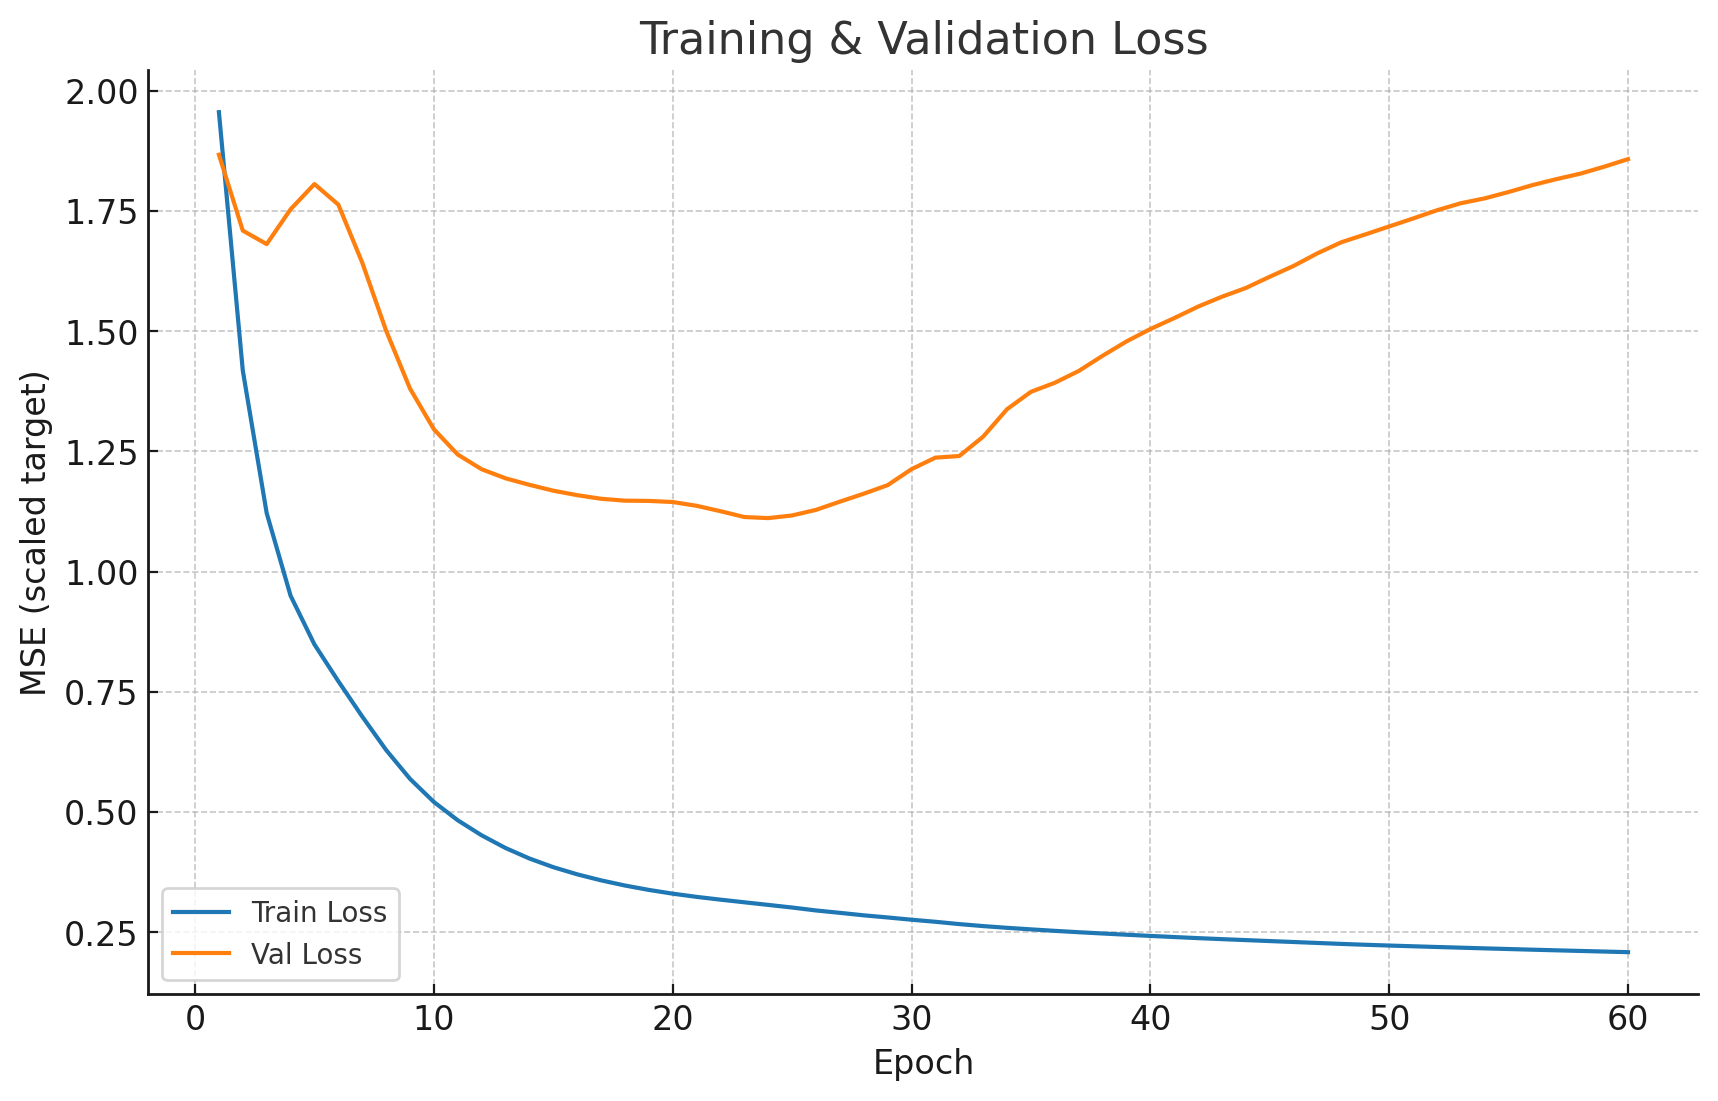

it shows that ➡
this model isn’t good as trained. It’s heavily <b>overfitting.</b>

What the plot shows:
*  Train loss falls smoothly from ~1.95 → ~0.23.
*  Val loss drops only until about epoch ~23–25 (to ≈ 1.12), then climbs steadily to ≈ 1.85.

That widening gap (low train, rising val) = classic overfitting.

---

grad_norm_plot.png
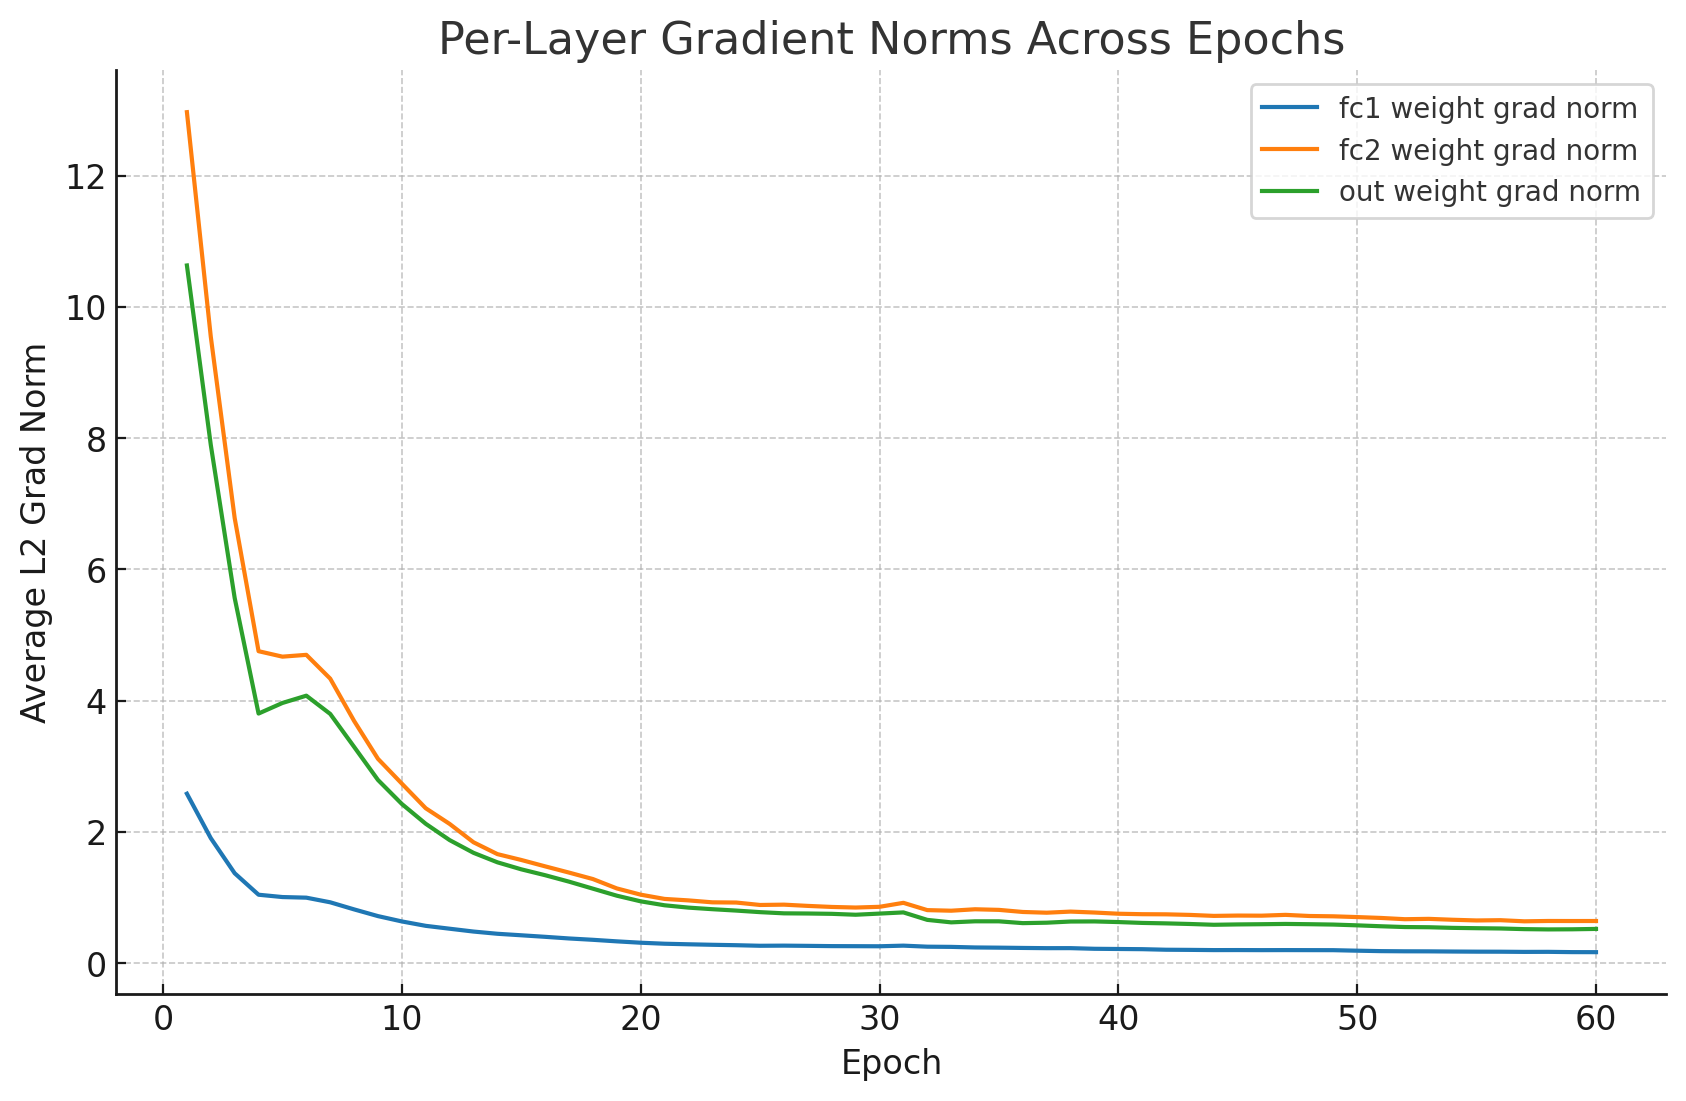

it shows that ➡

All layers’ gradient norms start high (fc2 ~13, output ~11, fc1 ~2.5) and drop sharply in the first ~5 epochs.

After ~epoch 20, gradient norms settle to a low, stable range (~0.2–0.8), with no sign of exploding or vanishing completely.

This means:

The optimizer is working fine—no exploding gradients.

No severe vanishing gradients either, though the first layer (fc1) naturally has smaller norms since it's farther from the loss.

---

The real problem is overfitting:
Your model continues to learn patterns that fit the training set (gradients still active), but those patterns don’t generalize—validation loss starts rising after ~epoch 24.
*  Conclusion from both plots
*  Gradients: ✅ Stable
*  Training stability: ✅ Fine
*  Generalization: ❌ Poor → Overfitting

The fix is about regularization & data handling, not gradient health:
Early stopping at ~epoch 24

---
Solutions i plan to implement -
*  Use early stopping and restore_best_weights (patience 3–5). Keep the checkpoint around epoch ~24.
*  <b>Strengthen regularization</b>: L2/weight decay (1e-4–1e-3), add/dropout (0.2–0.5), consider batch norm, and/or shrink the model (fewer layers/units).